# ChatGPT
In this notebook, we will explore ChatGPT and its use cases, along with possible optimization methods.

Chatbots simulate human-like conversation and have evolved from simple pattern matching to sophisticated language understanding and generation using machine learning techniques. Key milestones include ELIZA and ALICE, showcasing advancements in pattern matching and interaction complexity. The introduction of transformer models has enabled more efficient and contextually nuanced language understanding. ChatGPT, a recent development, is based on transformers and excels in generating coherent responses across diverse topics, with wide-ranging implications across industries and fields.


Nowadays, they are used for a variety of purposes, including searching, writing, offering explanations, and providing general support. More specialized applications encompass customer assistance chatbots and tutoring chatbots, which often necessitate additional optimization. This notebook will delve into various methods to enhance their performance in such contexts.

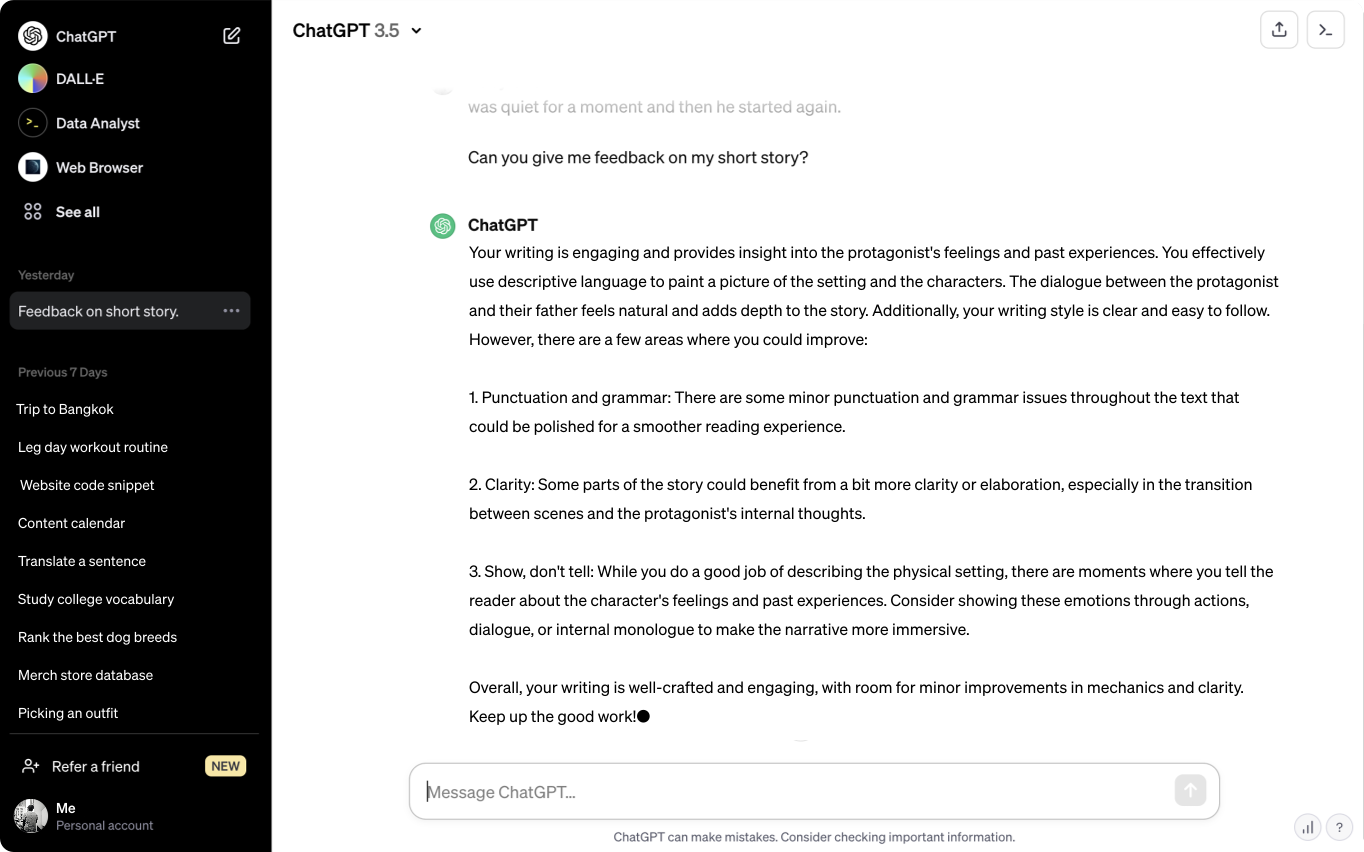

## Setup

In [2]:
#!pip install openai

In [82]:
from openai import AzureOpenAI
import os
import pandas as pd

To get the key for the openai API, first login into Microsoft Azure with your student's account. 

Then, go to the NOVAIMSPLAYGROUND resource, click on Resource Management on the left tab and on Keys and Endpoint. 

Choose one of the keys and the endpoint and set them as environmental variables. You can set them with os.environ like below or actually add them as environmental variables to your system using the terminal or the settings, so that you do not always need to run this code.

In [4]:
#os.environ["AZURE_OPENAI_API_KEY"]="3fb11fe5517445eb845c142213eca" (fake key)
#os.environ["AZURE_OPENAI_ENDPOINT"] = "https://novaimsplayground.openai.azure.com/" (endpoint should be the same)

For these notebooks and the project, the **gpt-35-turbo-16k** model will be used (the deployment name is "ChatGPT16k"). This corresponds to a specific version of **ChatGPT 3.5 Turbo** with a 16k context window (max request of 16,384 tokens) and includes training data up to September 2021. There are also rate limits in case of excessive requests (consider using time.sleep() or retrying with exponential backoff).

In [84]:
client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT"), 
  api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version="2024-02-01"
)

Let's start with a simple query:

In [ ]:
response = client.chat.completions.create(
    model="ChatGPT16k", # model = "deployment_name".
    messages=[
        {"role": "user", "content": "Write a description of ChatGPT capabilities."}
    ]
)
print(response.choices[0].message.content)

ChatGPT is a language model developed by OpenAI, designed to engage in interactive and dynamic conversations with users. It is proficient in understanding and generating text in a variety of topics. ChatGPT can answer questions, provide explanations, provide creative ideas, help with brainstorming, and have discussions on various subjects.

ChatGPT has the ability to contextually understand user inputs and respond accordingly, making the conversation feel more natural and conversational. It can carry on conversations across multiple turns, maintaining a consistent understanding of the ongoing discussion. ChatGPT leverages its vast knowledge base to produce coherent and context-aware responses.

While ChatGPT aims to be helpful and informative, it is important to note that it may sometimes generate responses that are incorrect or nonsensical. It is also sensitive to inputs and can produce biased or inappropriate content. OpenAI has incorporated safety mitigations to reduce harmful and m

Now, let's dive a bit deeper:

In [ ]:
response = client.chat.completions.create(
    model="ChatGPT16k", # model = "deployment_name".
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": "Does Azure OpenAI support customer managed keys?"},
        {"role": "assistant", "content": "Yes, customer managed keys are supported by Azure OpenAI."},
        {"role": "user", "content": "Do other Azure AI services support this too?"}
    ]
)

The role can take one of three values: 'system', 'user' or the 'assistant'.

The “system” provides instructions to guide the model's behavior, the “user” presents queries or prompts and the “assistant” corresponds to the model's response.

In [1]:
import tiktoken
tokenizer="cl100k_base"
def num_tokens(text: str, model: str = tokenizer) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.get_encoding(tokenizer)
    return len(encoding.encode(text))

In [2]:
num_tokens("You are a helpful assistant.")+num_tokens("Does Azure OpenAI support customer managed keys?")+num_tokens("Yes, customer managed keys are supported by Azure OpenAI.")+num_tokens("Do other Azure AI services support this too?")

36

Let's see the response we obtained:

In [ ]:
print(response)

ChatCompletion(id='chatcmpl-9K7byQ5pQ2IMA66yFsf2ezmyf1K0q', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Yes, other Azure AI services also support customer managed keys. These services include Azure Cognitive Services, Azure Machine Learning, and Azure Bot Service.', role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1714582846, model='gpt-35-turbo-16k', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=28, prompt_tokens=55, total_tokens=83), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'sever

As mentioned by ChatGPT, there are safety features implemented to prevent the generation of dangerous content. In case of there being an issue with the prompt, finish_reson will be 'content_filter' (content was omitted due to a flag in the content filters).
To go into more detail in the OpenAI documentation, click [here](https://platform.openai.com/docs/introduction)

In [ ]:
print(response.choices[0].message.content)

Yes, other Azure AI services also support customer managed keys. These services include Azure Cognitive Services, Azure Machine Learning, and Azure Bot Service.


## Prompt Engineering

Prompt engineering is the process of designing and optimizing the input prompts to guide the output of the LLM. This can help improve the versatility and relevance of the LLMs answers and counteract machine hallucinations (coherent outputs but factually incorrect). This should be the initial focus of the optimization, given its relatively simpler implementation. Numerous approaches exist for this purpose. Key elements of an effective prompt involve providing clear and precise instructions, employing role-prompting, and utilizing one-shot or few-shot prompts (providing one or multiple examples). Additionally, there are more advanced techniques like chain-of-thought and self-consistency.

**Use Case:** 
Use a news dataset from HuffPost to get a daily summary of political articles in a neutral, fact-based format.

In [ ]:
news_data=pd.read_json('News_Category_Dataset_v3.json',lines=True)
news_data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


For simplification, let's use only political news, where the headlines are not empty and days where there are exactly 5 news.

In [ ]:
news_data=news_data[news_data["headline"]!='']
news_data=news_data[news_data["category"]=="POLITICS"]
index=news_data["date"].value_counts()[news_data["date"].value_counts()==5].index
description_data=news_data[news_data["date"].isin(index)]
description_data = description_data.groupby('date')['headline'].apply(lambda x: '[sep]'.join(x)).reset_index()
description_data.head()

,date,headline
0,2014-05-14,Will Obama Relent on Syrian Anti-Aircraft Weap...
1,2014-06-19,Where Was God When Israel Deported African Ref...
2,2014-06-24,Gallup: The Lowest-Rated Living President Or E...
3,2014-08-08,Who Are the Yazidi?[sep]By Embracing Psycholog...
4,2014-10-02,12 Ways Parents Can Protect Their Kids From To...


In [ ]:
description_data.iloc[1]["headline"]

"Where Was God When Israel Deported African Refugees?[sep]Obama's Foreign Policy (or 'Lack Thereof')[sep]Republicans Hurl Harsh Accusations At Obama Administration[sep]Why Women Deserve Better From Washington[sep]The Whistleblower Protection Program Is Broken Too"

Optimize the prompt by testing iteratively. For instance, use one of the sets of short descriptions and test with ChatGPT until it gives the response you are looking for. When that happens, you can add that example to the system prompt (of course, you can also use an example that is not in the dataset you are going to use). 

**Example:** Questions arise about the moral implications of Israel's deportation of African refugees, while critiques of Obama's foreign policy and the Republican party's accusations against his administration surface. Discussions on gender equality in Washington and concerns about the malfunctioning whistleblower protection program also emerge.

In [ ]:
description_data["neutral_summary"]=""
for i in range(description_data.shape[0]):
    description_data["neutral_summary"].iloc[i] = client.chat.completions.create(
    model="ChatGPT16k", # model = "deployment_name".
    messages=[
        {"role": "system", "content": "You are an AI assistant that summarizes a set of headlines about political articles (separated by '[sep]') for a specific day in less than 3 sentences using fact-based and neutral language.\n Consider this example of a query and the answer you would give: \nQuery: 'Where Was God When Israel Deported African Refugees?[sep]Obama's Foreign Policy (or 'Lack Thereof')[sep]Republicans Hurl Harsh Accusations At Obama Administration[sep]Why Women Deserve Better From Washington[sep]The Whistleblower Protection Program Is Broken Too'\nAnswer: 'Questions arise about the moral implications of Israel's deportation of African refugees, while critiques of Obama's foreign policy and the Republican party's accusations against his administration surface. Discussions on gender equality in Washington and concerns about the malfunctioning whistleblower protection program also emerge.'"},
        {"role": "user", "content": description_data["headline"].iloc[i]}
    ]
    ).choices[0].message.content

C:\Users\migue\AppData\Local\Temp\ipykernel_1528\3893621464.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  description_data["neutral_summary"].iloc[i] = client.chat.completions.create(
C:\Users\migue\AppData\Local\Temp\ipykernel_1528\38

In [ ]:
description_data["headline"].iloc[0]

"Will Obama Relent on Syrian Anti-Aircraft Weapons?[sep]What I Realized When I Finally Decided To Sign Up For Food Stamps[sep]Paul Ryan's Approach To Poverty Is Straight Out Of The 19th Century[sep]Tea Party Favorite Wins Senate Primary[sep]Gay Missouri Rep: Michael Sam's Story Can Help Repeal Marriage Ban"

In [ ]:
description_data["neutral_summary"].iloc[0]

"There are discussions about whether Obama will change his position on providing anti-aircraft weapons to Syria, while personal reflections on signing up for food stamps and criticisms of Paul Ryan's approach to poverty emerge. Additionally, a Tea Party candidate wins a Senate primary, and a Missouri representative believes that Michael Sam's story can help repeal the marriage ban."

## Retrieval-augmented Generation (RAG)

RAG assists LLMs in producing more accurate and context-aware responses while minimizing errors by merging parametric memory learned during training with non-parametric memory sourced from an external knowledge base. <br>
A knowledge source (e.g. vector database) is determined based on the specific task of the language model. When the user writes its query, the model retrieves the most important information from this knowledge source and augments the query with this additional context. Thanks to the provided context, the model is able to generate accurate and factual responses. 
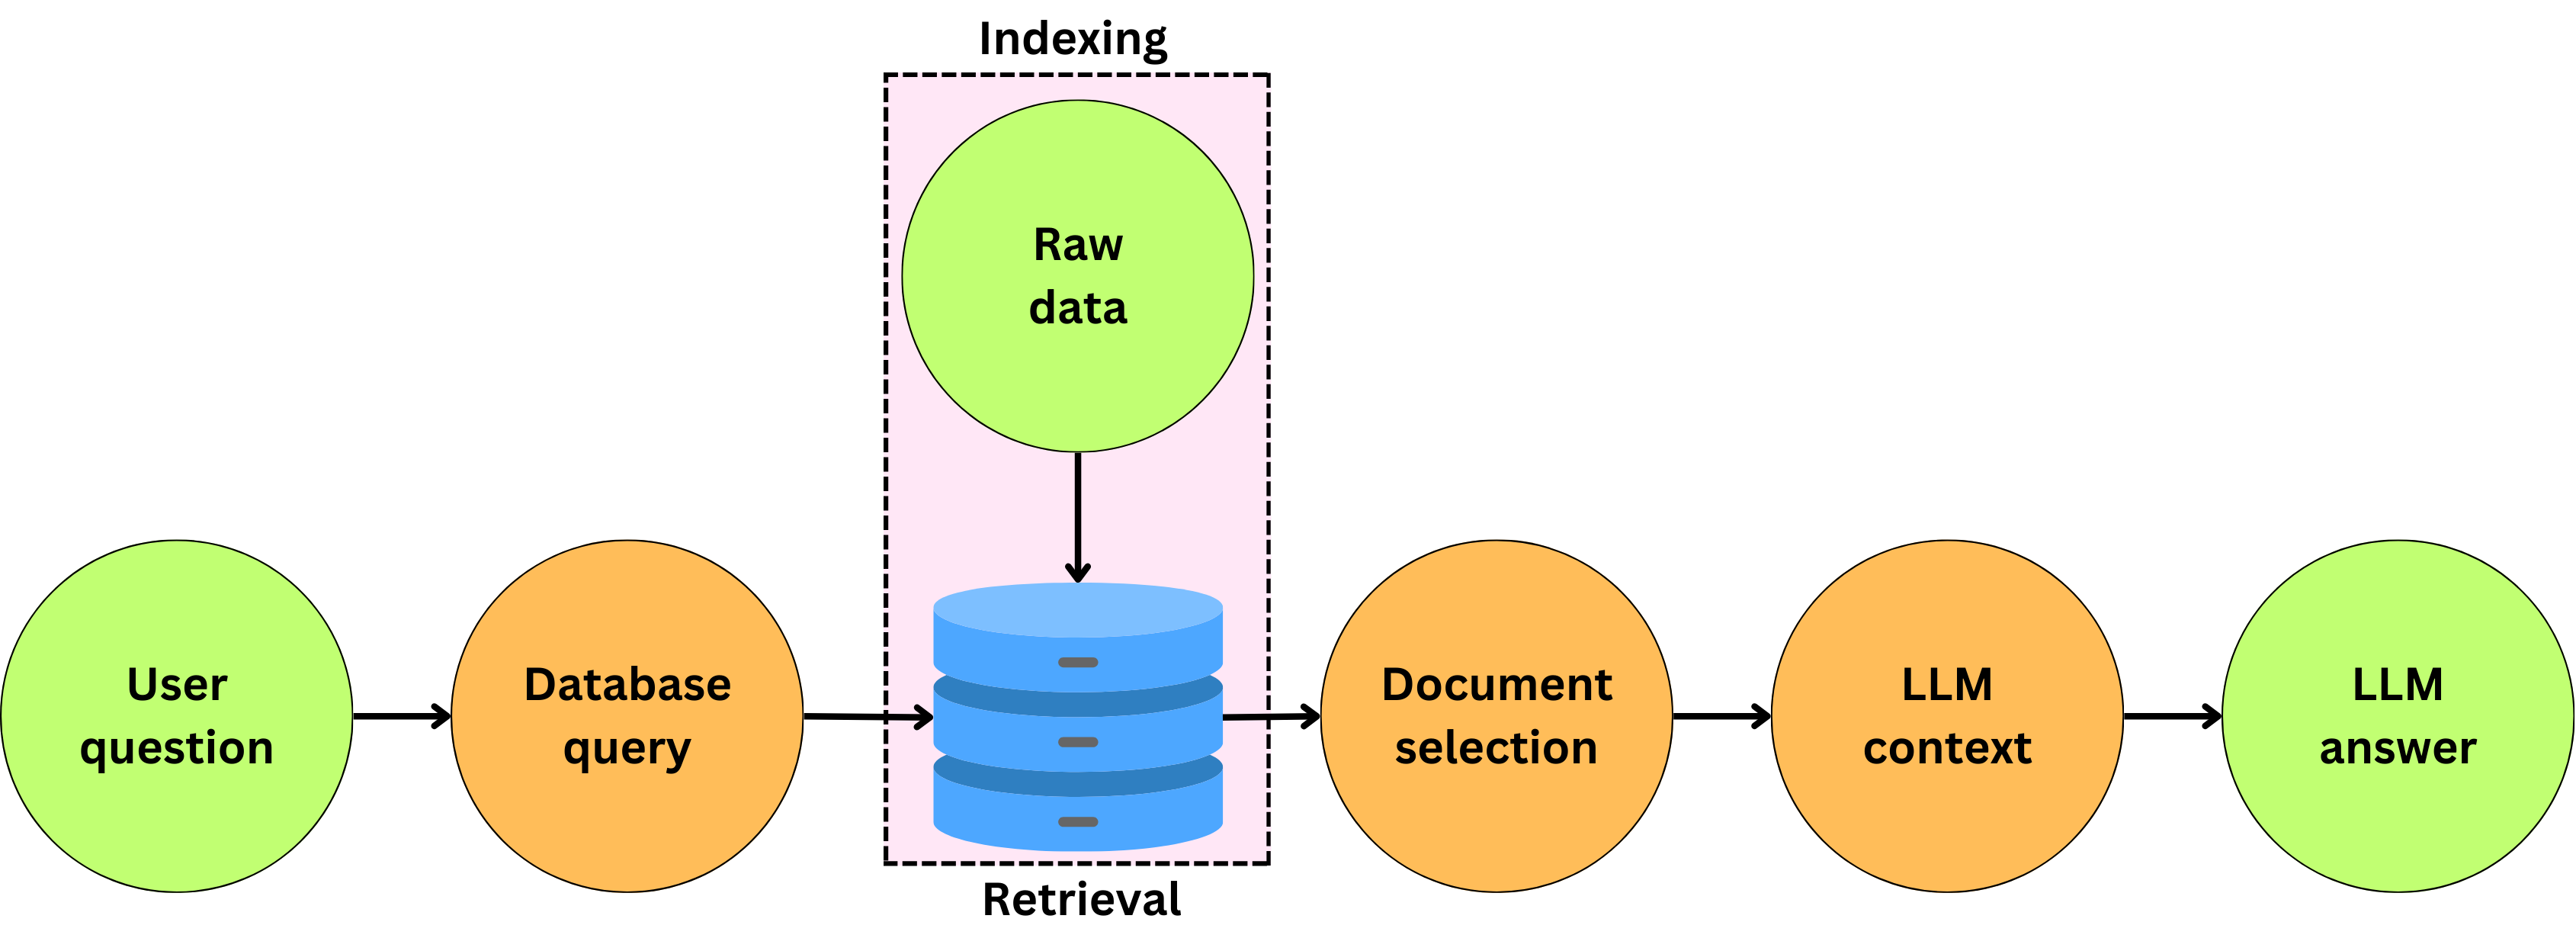
**Use Case:** 
Create a chatbot specialized in biomedical knowledge using the BioASQ dataset.

In [ ]:
#!pip install datasets

In [45]:
from datasets import load_dataset

knowledge_base = load_dataset("rag-datasets/mini-bioasq",'text-corpus')
test = load_dataset("rag-datasets/mini-bioasq",'question-answer-passages')

In [46]:
knowledge_base

DatasetDict({
    passages: Dataset({
        features: ['passage', 'id'],
        num_rows: 40221
    })
})

In [47]:
test

DatasetDict({
    test: Dataset({
        features: ['question', 'answer', 'relevant_passage_ids', 'id'],
        num_rows: 4719
    })
})

Let's start by transforming the datasets into an appropriate format.

In [48]:
knowledge_base=pd.DataFrame(knowledge_base)
knowledge_base['passages']=knowledge_base['passages'].apply(lambda x: x['passage'])
knowledge_base.head()

,passages
0,New data on viruses isolated from patients wit...
1,We describe an improved method for detecting d...
2,We have studied the effects of curare on respo...
3,Kinetic and electrophoretic properties of 230-...
4,Male Wistar specific-pathogen-free rats aged 2...


In [49]:
test=pd.DataFrame(test)
test['question']=test['test'].apply(lambda x:x['question'])
test['answer']=test['test'].apply(lambda x:x['answer'])
test['relevant_passage_ids']=test['test'].apply(lambda x:x['relevant_passage_ids'])
test.drop(columns=['test'],inplace=True)
test.head()

,question,answer,relevant_passage_ids
0,Is Hirschsprung disease a mendelian or a multi...,"Coding sequence mutations in RET, GDNF, EDNRB,...","[20598273, 6650562, 15829955, 15617541, 230011..."
1,List signaling molecules (ligands) that intera...,The 7 known EGFR ligands are: epidermal growt...,"[23821377, 24323361, 23382875, 22247333, 23787..."
2,Is the protein Papilin secreted?,"Yes, papilin is a secreted protein","[21784067, 19297413, 15094122, 7515725, 332004..."
3,Are long non coding RNAs spliced?,Long non coding RNAs appear to be spliced thro...,"[22955974, 21622663, 22707570, 22955988, 24285..."
4,Is RANKL secreted from the cells?,Receptor activator of nuclear factor κB ligand...,"[22867712, 23827649, 21618594, 23835909, 24265..."


### Retrieval

One of the ways to do the retrieval is to embed both the query and the documents in the knowledge base using the OpenAI text embeddings (we are using the model text-embedding-ada-002, which transforms a text input into 1536 dimensions - max input is 8191 tokens) and then find the documents with the highest cosine similarity to the query. This should correspond to the documents that are most similar to the query, thus containing the context needed for the chatbot to answer. <br>
To test, we are going to try to answer the third question in the test dataset: Is the protein Papilin secreted?

In [13]:
#!pip install langchain-openai

In [25]:
# The environmental variables need to be set up for this code to work
from langchain_openai import AzureOpenAIEmbeddings   
embedding_function=AzureOpenAIEmbeddings(
    azure_deployment="TextEmbeddings",
    openai_api_version="2024-02-01",
    max_retries=50
)

In [57]:
query_embedding=embedding_function.embed_query(test['question'].iloc[2])
query_embedding

[-0.010697555131553144,
 0.000726351124697237,
 0.007567879321742056,
 -0.019182751747866173,
 0.007972579004709272,
 -0.00023523153647440095,
 -0.002627173757787276,
 -0.011331583672501842,
 -0.024174046285590955,
 -0.002241022992673386,
 0.01857570268907661,
 0.02754654022880183,
 -0.007857913644396008,
 0.01745603508736077,
 -0.01347649115403781,
 0.0018683623178850093,
 0.027006941272393892,
 -0.0023540017278980995,
 0.005564617148339748,
 0.002898659628249164,
 -0.006728127689132653,
 0.004276323825008588,
 0.0013270768528038366,
 -0.008215398069431583,
 -0.008411002807544775,
 0.010353559981935876,
 -0.0025732138621464822,
 -0.039147922448185116,
 0.003696254714039423,
 -0.01885899237402141,
 0.017604424567542323,
 0.012815482199607455,
 -0.010225405346204306,
 0.013463000947296981,
 -0.015189718539124908,
 -0.0067753429470642935,
 0.0036827647401292247,
 0.0017452662768506193,
 0.018197984350913576,
 0.010886414300634662,
 0.032402934561763366,
 0.01002305597038196,
 0.010319834

In [58]:
len(query_embedding)

1536

To answer the question, we will need to embed all the documents in the knowledge base to then calculate the cosine similarity and find the most similar documents to the query (in this case, let's retrieve only 1 - the one with the highest similarity). 

In [38]:
knowledge_base['embeddings']=knowledge_base['passages'].apply(lambda x: embedding_function.embed_query(x))

In [59]:
knowledge_base

,passages,embeddings
0,New data on viruses isolated from patients wit...,"[-0.01201836213044982, 0.020041700879312885, 0..."
1,We describe an improved method for detecting d...,"[-0.004906511026495951, 0.018208904534252793, ..."
2,We have studied the effects of curare on respo...,"[-0.011923597228784423, 0.014620438049813134, ..."
3,Kinetic and electrophoretic properties of 230-...,"[0.003346760078789907, -0.002948101888140479, ..."
4,Male Wistar specific-pathogen-free rats aged 2...,"[-0.01077853081354698, -0.007460525010166667, ..."
...,...,...
40216,LncRNAs are involved in the occurrence and pro...,"[-0.016832332476400896, -0.003123679788863627,..."
40217,BACKGROUND: COVID-19 patients with long incuba...,"[0.023934889225062986, 0.008463668237108877, 0..."
40218,Spinal muscular atrophy (SMA) is an autosomal ...,"[-0.030226997953895707, 0.01054992030290728, -..."
40219,Amphiregulin (AREG) is an epidermal growth fac...,"[-0.01909215345753215, -0.01773328119937948, -..."


In [70]:
literal_eval(knowledge_base['embeddings'].iloc[0])

[-0.01201836213044982,
 0.020041700879312885,
 0.018297207162173135,
 -0.025501566043305116,
 -0.010759929355468089,
 0.027911897611590998,
 -0.0072309923765513755,
 -0.008329623713355482,
 -0.02691314176619431,
 -0.008649225658388224,
 0.010613445363492043,
 0.01812408920911644,
 -0.0046042642982671335,
 -0.006957998932087262,
 0.006488583982774022,
 0.012923900974709253,
 0.028471199618414534,
 -0.012824025017640581,
 0.017964289167922576,
 -0.00932837955875217,
 -0.018177357131277737,
 0.021852778567831754,
 -0.004491072291980644,
 -0.02422315826317415,
 -0.009574739507796888,
 0.031747119089338874,
 -0.0011385816963485128,
 -0.03582204249152256,
 -0.01949571492170717,
 0.008069947715092948,
 0.012837341998180906,
 -0.00555308263079074,
 -0.004514376309434331,
 0.0009321721068482009,
 0.0027732120702602886,
 -0.009101994614856685,
 0.008928877593122499,
 -0.004387867322607518,
 0.018616809107205878,
 0.007830245790657138,
 0.016845681428985477,
 0.006338770512832268,
 0.003981706866

In [72]:
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval
import numpy as np
max_similarity = -1
max_index = -1

for i in range(knowledge_base.shape[0]):
    similarity = cosine_similarity([query_embedding], [literal_eval(knowledge_base['embeddings'].iloc[i])])
    if similarity > max_similarity:
        max_similarity = similarity
        max_index = i

max_index, max_similarity

(7017, array([[0.8629298]]))

In [73]:
knowledge_base['passages'].iloc[max_index]

'Papilins are homologous, secreted extracellular matrix proteins which share a \ncommon order of protein domains. They occur widely, from nematodes to man, and \ncan differ in the number of repeats of a given type of domain. Within one \nspecies the number of repeats can vary by differential RNA splicing. A \ndistinctly conserved cassette of domains at the amino-end of papilins is \nhomologous with a cassette of protein domains at the carboxyl-end of the ADAMTS \nsubgroup of secreted, matrix-associated metalloproteases. Papilins primarily \noccur in basement membranes. Papilins interact with several extracellular matrix \ncomponents and ADAMTS enzymes. Papilins are essential for embryonic development \nof Drosophila melanogaster and Caenorhabditis elegans.'

It contains the information we needed as right in the first sentence it confirms that Papilins are secreted.

### Augmentation

Now that we have found the needed context to answer the query, we augment the user prompt with that context. As well as that, a system prompt is again defined considering prompt engineering's best practices, such as role-prompting and the inclusion of an example, and with new information to explain to the chatbot that it will have access to additional context. <br>
One of the test's pair of question and answer is included in the prompt, thus it cannot be used when evaluating the model.

In [86]:
# This is just for explanation purposes. In practice, you need to be careful with the spaces in the string. It will correspond to additional 
#tokens but the delimeters/spacing you use help the prompt be more understandable to the chatbot.
system_prompt='''You are a question-answering chatbot specialized in biomedicine. Example of a question and the answer you would give: 
        Question - Is RANKL secreted from the cells?; 
        Response - Receptor activator of nuclear factor κB ligand (RANKL) is a cytokine predominantly secreted by osteoblasts.
        With each user message, you get access to important documents containing information relevant to the question 
        and the actual question of the user. If the answer cannot be found in the information given, write "I am sorry but I could not find 
        an answer."'''
user_prompt= 'Information:/n'+knowledge_base['passages'].iloc[max_index]+'/nQuestion:/n'+test['question'].iloc[2]

Finally, with these prompts we can generate an answer.

### Generation

In [87]:
response = client.chat.completions.create(
    model="ChatGPT16k", 
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
)
print(response.choices[0].message.content)

Yes, the protein Papilin is secreted. Papilins are secreted extracellular matrix proteins that occur in basement membranes and interact with several extracellular matrix components and ADAMTS enzymes.


In [88]:
test['answer'].iloc[2]

'Yes,  papilin is a secreted protein'

It was able to get the correct answer although with additional information. We could try to work with the prompt in case we want the model to give more concise answers. <br>
We will explore RAG in more detail in the next class.

## Fine-tuning

Fine-tuning involves modifying the model's parameters using a smaller, task-specific dataset. It differs from prompt engineering and RAG as they solely alter the prompt. According to ​OpenAI, fine-tuning is effective for emphasizing existing knowledge within the model, customizing response structure or tone, and teaching a model highly complex instructions. However, it is not good for incorporating new knowledge into the base model (RAG is more suitable for this purpose) or rapidly iterating on a new use case due to the substantial effort it requires compared to other alternatives. 

Good example of fine-tuning in practice: https://www.youtube.com/watch?v=VVKcSf6r3CM

**Use Cases:** <br>
Add sarcasm to our chatbot. <br>
Create a tutoring chatbot that follows the Socratic method.

## Final considerations

​​OpenAI structured the optimization flow using two axes: Context optimization (what the model needs to know) and LLM optimization (how the model needs to act), as can be seen in the figure below: 

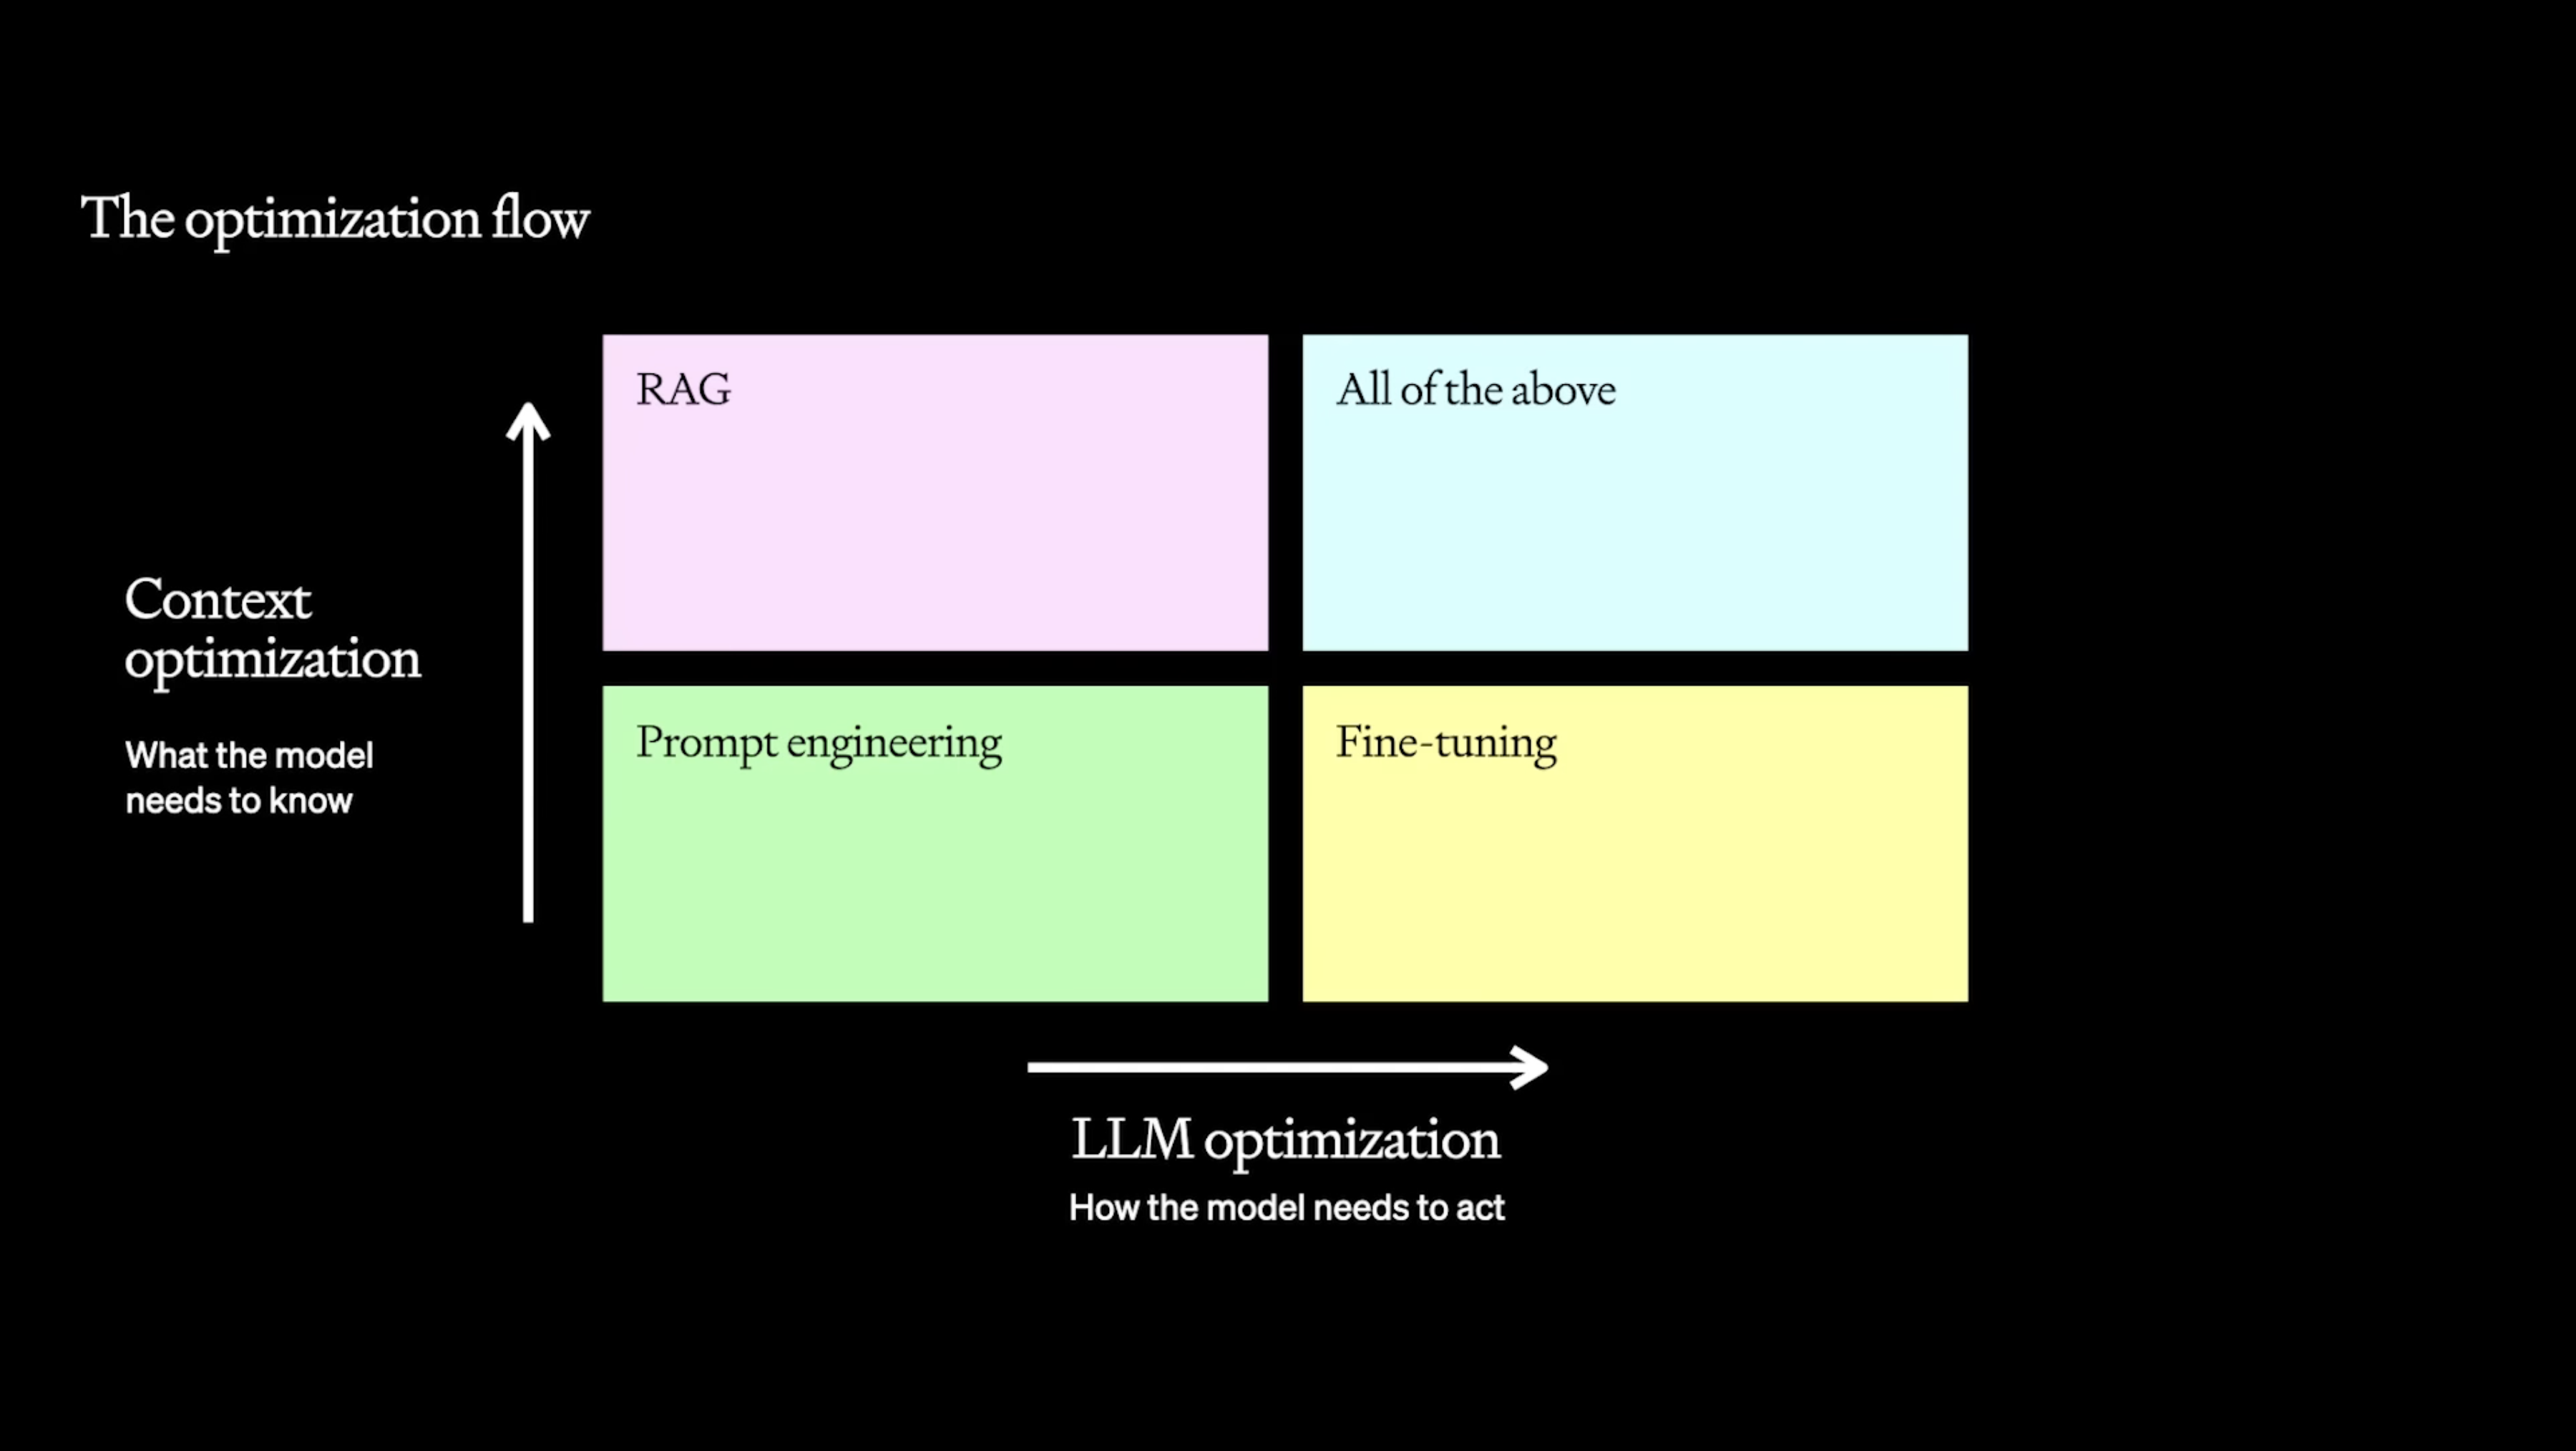

Prompt engineering serves as an initial solution that can enhance both the model's behaviour and its existing knowledge. RAG is particularly advantageous for refining the model's knowledge (optimizing its context), whereas fine-tuning aids in instructing the model with established behaviors. In certain use cases, all these solutions can be employed simultaneously. <br>
To go into more detail in these optimization methods, consider watching this OpenAI presentation: https://www.youtube.com/watch?v=ahnGLM-RC1Y.